# All imports necessary

In [1]:
import os

In [2]:
import sys

In [3]:
import lightgbm as lgb

In [4]:
import xgboost as xgb

In [5]:
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import multiprocessing

In [10]:
sys.path.append('..')

In [11]:
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import auc

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
from sklearn.preprocessing import OrdinalEncoder

In [19]:
from sklearn.compose import ColumnTransformer

In [20]:
from sklearn.metrics import roc_curve

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
from source.code.transformers.metafeaturesextractor import MetaFeaturesExtractor

In [24]:
from source.code.models.svdbasedrecommender import SVDBasedRecommender

In [25]:
from source.code.models.songfrequencybasedrecommender import SongFrequencyBasedRecommender

In [26]:
from source.code.models.factorizationmachinebasedrecommender import FactorizationMachineBasedRecommender

In [27]:
from source.code.models.lightgbmbasedrecommender import LightGBMBasedRecommender

In [28]:
from source.code.models.xgboostbasedrecommender import XGBoostBasedRecommender

In [29]:
from source.code.models.ensemblebasedrecommender import EnsembleBasedRecommender

In [30]:
from tqdm.autonotebook import tqdm

# Auxiliary methods

In [31]:
def plot_roc_auc(fpr, tpr, classifier):
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example ({})'.format(classifier))
    plt.legend(loc="lower right")
    plt.show()

# Read the data

In [32]:
data_directory = '../data/datasets/'

In [33]:
unknown_category_label = 'unknown'

In [34]:
unknown_language_label = -1

## Train

In [35]:
train = pd.read_csv(os.path.join(data_directory, 'train.csv'), engine='python')

In [36]:
train.head(4).T

,0,1,2,3
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
source_system_tab,explore,my library,my library,my library
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more
source_type,online-playlist,local-playlist,local-playlist,local-playlist
target,1,1,1,1


In [37]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  7377418 non-null object
song_id               7377418 non-null object
source_system_tab     7352569 non-null object
source_screen_name    6962614 non-null object
source_type           7355879 non-null object
target                7377418 non-null int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


## Test

In [38]:
test = pd.read_csv(os.path.join(data_directory, 'test.csv'), engine='python')

In [39]:
test.head(4).T

,0,1,2,3
id,0,1,2,3
msno,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=
song_id,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=
source_system_tab,my library,my library,discover,radio
source_screen_name,Local playlist more,Local playlist more,NaN,Radio
source_type,local-library,local-library,song-based-playlist,radio


In [40]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
id                    2556790 non-null int64
msno                  2556790 non-null object
song_id               2556790 non-null object
source_system_tab     2548348 non-null object
source_screen_name    2393907 non-null object
source_type           2549493 non-null object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


## Songs

In [41]:
songs = pd.read_csv(os.path.join(data_directory, 'songs.csv'))

In [42]:
songs.head(4).T

,0,1,2,3
song_id,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=
song_length,247640,197328,231781,273554
genre_ids,465,444,465,465
artist_name,張信哲 (Jeff Chang),BLACKPINK,SUPER JUNIOR,S.H.E
composer,董貞,TEDDY| FUTURE BOUNCE| Bekuh BOOM,NaN,湯小康
lyricist,何啟弘,TEDDY,NaN,徐世珍
language,3,31,31,3


In [43]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        2296320 non-null object
song_length    2296320 non-null int64
genre_ids      2202204 non-null object
artist_name    2296320 non-null object
composer       1224966 non-null object
lyricist       351052 non-null object
language       2296319 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


## Members

In [44]:
members = pd.read_csv(os.path.join(data_directory, 'members.csv'))

In [45]:
members.head(4).T

,0,1,2,3
msno,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=
city,1,1,1,1
bd,0,0,0,0
gender,NaN,NaN,NaN,NaN
registered_via,7,7,4,9
registration_init_time,20110820,20150628,20160411,20150906
expiration_date,20170920,20170622,20170712,20150907


In [46]:
members.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null object
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null object
registered_via            34403 non-null int64
registration_init_time    34403 non-null int64
expiration_date           34403 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


## Sample submission

In [47]:
sample_submission = pd.read_csv(os.path.join(data_directory, 'sample_submission.csv'))

In [48]:
sample_submission.head(4).T

,0,1,2,3
id,0.0,1.0,2.0,3.0
target,0.5,0.5,0.5,0.5


In [49]:
sample_submission.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        2556790 non-null int64
target    2556790 non-null float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB


# Solutions

## Train / Test split preparation

In [50]:
X, y = train[train.columns[:-1]], train[train.columns[-1]]

In [51]:
X_for_submission = test[test.columns]

In [ ]:
X.head(4).T

In [ ]:
y.head(4).T

In [ ]:
X_for_submission.head(4).T

In [ ]:
X[['msno', 'song_id']].values.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
print(type(X_train), type(y_train))

In [ ]:
print(X_test.shape, y_test.shape)

In [ ]:
print(type(X_test), type(y_test))

## Preprocessing steps description

In [52]:
categorical_features = [
    'source_system_tab',
    'source_screen_name',
    'city',
    'gender'
]

In [53]:
categorical_features_lang = [
    'language'
]

In [54]:
numerical_features = [
    'bd',
    'song_length'
]

In [55]:
numerical_features_days_reg = [
    'days_registered'
]

In [56]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [57]:
num_features_pipeline_days_reg = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [58]:
cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_category_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [59]:
cat_features_pipeline_lang = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_language_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, numerical_features),
        ('num_days_reg', num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', cat_features_pipeline, categorical_features),
        ('cat_lang', cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [61]:
unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('preprocessing', preprocessor)
    ]
)

## Naive frequency approach

In [ ]:
naive_frequency_recommender = SongFrequencyBasedRecommender()

In [ ]:
naive_frequency_recommender.fit(X_train, y_train)

In [ ]:
y_pred = naive_frequency_recommender.predict_proba(X_test)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'Naive frequency approach')

## SVD

In [ ]:
svd_recommender = SVDBasedRecommender()

In [ ]:
svd_recommender.fit(X_train, y_train)

In [ ]:
y_pred = svd_recommender.predict_proba(X_test)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'SVD approach')

## FM

In [ ]:
fm_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', FactorizationMachineBasedRecommender(show_progress=True))
    ]
)

In [ ]:
fm_classifier_pipeline.fit(X_train, y_train.values)

In [ ]:
y_pred = fm_classifier_pipeline.predict_proba(X_test)

In [ ]:
y_pred.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'Factorization machine approach')

## LightGBM

In [ ]:
lgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', LightGBMBasedRecommender())
    ]
)

In [ ]:
lgb_classifier_pipeline.fit(X_train, y_train.values)

In [ ]:
y_pred = lgb_classifier_pipeline.predict_proba(X_test)

In [ ]:
y_pred.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'LightGBM classifier approach')

## XGBoost

In [ ]:
xgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', XGBoostBasedRecommender())
    ]
)

In [ ]:
xgb_classifier_pipeline.fit(X_train, y_train.values)

In [ ]:
y_pred = xgb_classifier_pipeline.predict_proba(X_test)

In [ ]:
y_pred.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'XGBoost classifier approach')

## StarSpace

In [72]:
star_space_num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='ordinal'))
])

In [73]:
star_space_num_features_pipeline_days_reg = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='ordinal'))
])

In [74]:
star_space_cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_category_label)),
    ('encode', OrdinalEncoder())
])

In [75]:
star_space_cat_features_pipeline_lang = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_language_label)),
    ('encode', OrdinalEncoder())
])

In [76]:
star_space_preprocessor = ColumnTransformer(
    transformers=[
        ('num', star_space_num_features_pipeline, numerical_features),
        ('num_days_reg', star_space_num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', star_space_cat_features_pipeline, categorical_features),
        ('cat_lang', star_space_cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [77]:
star_space_unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('preprocessing', star_space_preprocessor)
    ]
)

In [78]:
X_star_space = star_space_unified_pipeline.fit_transform(X, y)

In [79]:
X.shape

(7377418, 5)

In [80]:
numerical_features + numerical_features_days_reg + categorical_features + categorical_features_lang

['bd',
 'song_length',
 'days_registered',
 'source_system_tab',
 'source_screen_name',
 'city',
 'gender',
 'language']

In [81]:
X_star_space.shape

(7377418, 8)

In [82]:
X_star_space = pd.DataFrame(X_star_space, columns=numerical_features + numerical_features_days_reg + categorical_features + categorical_features_lang)

In [83]:
X_star_space.head()

,bd,song_length,days_registered,source_system_tab,source_screen_name,city,gender,language
0,1.0,0.0,2.0,1.0,7.0,0.0,2.0,8.0
1,2.0,3.0,3.0,3.0,8.0,11.0,0.0,8.0
2,2.0,1.0,3.0,3.0,8.0,11.0,0.0,8.0
3,2.0,2.0,3.0,3.0,8.0,11.0,0.0,0.0
4,1.0,0.0,2.0,1.0,7.0,0.0,2.0,8.0


In [84]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null float64
song_length           7377418 non-null float64
days_registered       7377418 non-null float64
source_system_tab     7377418 non-null float64
source_screen_name    7377418 non-null float64
city                  7377418 non-null float64
gender                7377418 non-null float64
language              7377418 non-null float64
dtypes: float64(8)
memory usage: 450.3 MB


In [85]:
X_star_space.bd = X_star_space.bd.astype(np.int32)
X_star_space.song_length = X_star_space.song_length.astype(np.int32)
X_star_space.days_registered = X_star_space.days_registered.astype(np.int32)
X_star_space.source_system_tab = X_star_space.source_system_tab.astype(np.int32)
X_star_space.source_screen_name = X_star_space.source_screen_name.astype(np.int32)
X_star_space.city = X_star_space.city.astype(np.int32)
X_star_space.gender = X_star_space.gender.astype(np.int32)
X_star_space.language = X_star_space.language.astype(np.int32)

In [86]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null int32
song_length           7377418 non-null int32
days_registered       7377418 non-null int32
source_system_tab     7377418 non-null int32
source_screen_name    7377418 non-null int32
city                  7377418 non-null int32
gender                7377418 non-null int32
language              7377418 non-null int32
dtypes: int32(8)
memory usage: 225.1 MB


In [87]:
curr = 0

In [88]:
bd_map = dict(zip(X_star_space.bd.unique(), range(curr, curr + len(X_star_space.bd.unique()))))
curr += len(X_star_space.bd.unique())

In [89]:
song_length_map = dict(zip(X_star_space.song_length.unique(), range(curr, curr + len(X_star_space.song_length.unique()))))
curr += len(X_star_space.song_length.unique())

In [90]:
days_registered_map = dict(zip(X_star_space.days_registered.unique(), range(curr, curr + len(X_star_space.days_registered.unique()))))
curr += len(X_star_space.days_registered.unique())

In [91]:
source_system_tab_map = dict(zip(X_star_space.source_system_tab.unique(), range(curr, curr + len(X_star_space.source_system_tab.unique()))))
curr += len(X_star_space.source_system_tab.unique())

In [92]:
source_screen_name_map = dict(zip(X_star_space.source_screen_name.unique(), range(curr, curr + len(X_star_space.source_screen_name.unique()))))
curr += len(X_star_space.source_screen_name.unique())

In [93]:
city_map = dict(zip(X_star_space.city.unique(), range(curr, curr + len(X_star_space.city.unique()))))
curr += len(X_star_space.city.unique())

In [94]:
gender_map = dict(zip(X_star_space.gender.unique(), range(curr, curr + len(X_star_space.gender.unique()))))
curr += len(X_star_space.gender.unique())

In [95]:
language_map = dict(zip(X_star_space.language.unique(), range(curr, curr + len(X_star_space.language.unique()))))

In [96]:
bd_map

{0: 3, 1: 0, 2: 1, 3: 2}

In [97]:
song_length_map

{0: 4, 1: 6, 2: 7, 3: 5}

In [98]:
days_registered_map

{0: 11, 1: 10, 2: 8, 3: 9}

In [99]:
source_system_tab_map

{0: 15, 1: 12, 2: 18, 3: 13, 4: 19, 5: 17, 6: 14, 7: 20, 8: 16}

In [100]:
source_screen_name_map

{0: 26,
 1: 31,
 2: 40,
 3: 29,
 4: 27,
 5: 35,
 6: 38,
 7: 21,
 8: 22,
 9: 24,
 10: 36,
 11: 25,
 12: 33,
 13: 41,
 14: 30,
 15: 32,
 16: 37,
 17: 34,
 18: 39,
 19: 28,
 20: 23}

In [101]:
city_map

{0: 42,
 1: 58,
 2: 50,
 3: 45,
 4: 51,
 5: 59,
 6: 55,
 7: 46,
 8: 54,
 9: 56,
 10: 49,
 11: 43,
 12: 52,
 13: 44,
 14: 61,
 15: 53,
 16: 57,
 17: 62,
 18: 60,
 19: 47,
 20: 48}

In [102]:
gender_map

{0: 64, 1: 65, 2: 63}

In [103]:
language_map

{0: 67, 1: 69, 2: 71, 3: 70, 4: 72, 5: 68, 6: 75, 7: 74, 8: 66, 9: 73}

In [104]:
X_star_space.bd = X_star_space.bd.map(bd_map)
X_star_space.song_length = X_star_space.song_length.map(song_length_map)
X_star_space.days_registered = X_star_space.days_registered.map(days_registered_map)
X_star_space.source_system_tab = X_star_space.source_system_tab.map(source_system_tab_map)
X_star_space.source_screen_name = X_star_space.source_screen_name.map(source_screen_name_map)
X_star_space.city = X_star_space.city.map(city_map)
X_star_space.gender = X_star_space.gender.map(gender_map)
X_star_space.language = X_star_space.language.map(language_map)

In [105]:
X_star_space.head()

,bd,song_length,days_registered,source_system_tab,source_screen_name,city,gender,language
0,0,4,8,12,21,42,63,66
1,1,5,9,13,22,43,64,66
2,1,6,9,13,22,43,64,66
3,1,7,9,13,22,43,64,67
4,0,4,8,12,21,42,63,66


In [106]:
X_star_space.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 8 columns):
bd                    7377418 non-null int64
song_length           7377418 non-null int64
days_registered       7377418 non-null int64
source_system_tab     7377418 non-null int64
source_screen_name    7377418 non-null int64
city                  7377418 non-null int64
gender                7377418 non-null int64
language              7377418 non-null int64
dtypes: int64(8)
memory usage: 450.3 MB


In [ ]:
X_star_space = pd.concat([X[['msno', 'song_id']], X_star_space], axis=1)

In [ ]:
X_star_space.info(verbose=True, null_counts=True)

In [ ]:
X_star_space.to_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'X_star_space.csv'), index=False, header=False, sep=' ')

In [ ]:
# Code for StarSpace installation:
# TBD on new machine

In [ ]:
! ../../Starspace/starspace

In [ ]:
! ../../Starspace/starspace train \
-trainFile /mnt/PROMO_INVESTIGATION_DATA/X_star_space.csv \
-model /mnt/PROMO_INVESTIGATION_DATA/star_space_model \
-trainMode 5

In [62]:
X_star_space_emb = pd.read_csv(os.path.join('/mnt/PROMO_INVESTIGATION_DATA/', 'star_space_model.tsv'), delimiter='\t', header=None)

In [63]:
X_star_space_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [64]:
# SSF stands for StarSpace Feature
X_star_space_emb.columns = ['SSF_{}'.format(i) for i in range(101)]

In [65]:
X_star_space_emb.head()

,SSF_0,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [66]:
X_star_space_emb.rename({"SSF_0": "WORD"}, axis=1, inplace=True)

In [67]:
X_star_space_emb.head()

,WORD,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
1,13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
2,0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
3,22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
4,63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07


In [68]:
X_star_space_emb.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 101 columns):
WORD       76 non-null int64
SSF_1      76 non-null float64
SSF_2      76 non-null float64
SSF_3      76 non-null float64
SSF_4      76 non-null float64
SSF_5      76 non-null float64
SSF_6      76 non-null float64
SSF_7      76 non-null float64
SSF_8      76 non-null float64
SSF_9      76 non-null float64
SSF_10     76 non-null float64
SSF_11     76 non-null float64
SSF_12     76 non-null float64
SSF_13     76 non-null float64
SSF_14     76 non-null float64
SSF_15     76 non-null float64
SSF_16     76 non-null float64
SSF_17     76 non-null float64
SSF_18     76 non-null float64
SSF_19     76 non-null float64
SSF_20     76 non-null float64
SSF_21     76 non-null float64
SSF_22     76 non-null float64
SSF_23     76 non-null float64
SSF_24     76 non-null float64
SSF_25     76 non-null float64
SSF_26     76 non-null float64
SSF_27     76 non-null float64
SSF_28     76 non-null float64

In [69]:
X_star_space_emb.set_index('WORD', inplace=True)

In [70]:
X_star_space_emb

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
WORD,,,,,,,,,,,,,,,,,,,,,
69,1.224700e-06,-6.339670e-08,-1.767400e-06,7.851660e-07,-8.879650e-07,4.266440e-07,1.396810e-06,6.857180e-07,-1.031300e-06,7.571830e-07,...,-1.130790e-07,4.756250e-07,-4.377710e-07,-9.531500e-07,2.851450e-07,2.821770e-07,5.006500e-07,-2.463790e-06,-1.085030e-06,9.553340e-07
13,2.733760e-08,3.589730e-09,-3.291410e-08,1.603410e-08,-2.281670e-08,4.153110e-09,2.350510e-08,1.099790e-08,-1.490610e-08,7.885580e-09,...,-1.206110e-08,5.734250e-09,-4.669810e-09,-1.771730e-08,2.809160e-09,1.248170e-09,7.941900e-09,-4.643670e-08,-1.146920e-08,1.593460e-08
0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,-7.174000e-07,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
22,3.269010e-08,4.032160e-09,-4.015310e-08,1.966790e-08,-2.762200e-08,5.168260e-09,2.793920e-08,1.245500e-08,-1.747600e-08,9.077260e-09,...,-1.441370e-08,6.554140e-09,-5.545750e-09,-2.023560e-08,3.487980e-09,1.567720e-09,9.058400e-09,-5.494460e-08,-1.409680e-08,1.864190e-08
63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,6.226500e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07
42,1.125690e-08,3.017250e-10,-1.603960e-08,7.729870e-09,-6.484850e-09,3.591270e-09,1.743080e-08,1.138790e-08,-1.368310e-08,1.077520e-08,...,2.458290e-10,1.022630e-08,-6.023820e-09,-1.263620e-08,3.580050e-09,2.304400e-09,7.835510e-09,-3.044890e-08,-1.203900e-08,1.421310e-08
65,9.234820e-07,-2.416270e-08,-1.311110e-06,6.131700e-07,-6.574110e-07,2.891610e-07,1.006020e-06,4.911600e-07,-7.885510e-07,5.204070e-07,...,-6.535980e-08,3.322310e-07,-3.004810e-07,-7.342750e-07,2.400570e-07,2.122500e-07,3.500200e-07,-1.803450e-06,-8.060320e-07,7.126480e-07
15,1.058430e-07,1.543100e-08,-1.274760e-07,8.992550e-08,-3.990970e-08,4.853720e-08,1.113130e-07,7.197520e-08,-1.547280e-07,5.322580e-08,...,5.707940e-08,9.243990e-08,-4.875610e-08,-9.152910e-08,6.622350e-08,4.684290e-08,4.116620e-08,-2.095890e-07,-1.369060e-07,1.369000e-07
64,8.862840e-07,-2.759630e-08,-1.302990e-06,6.094610e-07,-6.670260e-07,3.162820e-07,1.008400e-06,4.892820e-07,-7.926750e-07,5.146000e-07,...,-7.550480e-08,3.141280e-07,-2.933490e-07,-7.295100e-07,2.275120e-07,2.242390e-07,3.481140e-07,-1.785800e-06,-7.770550e-07,7.182610e-07


In [107]:
X_star_space.loc[0]

bd                     0
song_length            4
days_registered        8
source_system_tab     12
source_screen_name    21
city                  42
gender                63
language              66
Name: 0, dtype: int64

In [108]:
X_star_space_emb.loc[X_star_space.loc[4]]

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
WORD,,,,,,,,,,,,,,,,,,,,,
0,-1.356260e-06,1.001750e-07,2.075460e-06,-8.650810e-07,9.390600e-07,-5.241360e-07,-1.418820e-06,-6.180480e-07,1.200500e-06,-7.174000e-07,...,8.630100e-08,-3.574820e-07,4.290890e-07,1.021510e-06,-3.258210e-07,-3.851790e-07,-4.998520e-07,2.507770e-06,1.210360e-06,-1.010100e-06
4,-4.812270e-07,4.084920e-08,7.005940e-07,-2.684940e-07,3.438240e-07,-1.657010e-07,-5.519390e-07,-2.725110e-07,3.980780e-07,-3.044820e-07,...,2.116550e-08,-1.596280e-07,1.825300e-07,3.970640e-07,-8.019650e-08,-1.178420e-07,-2.235920e-07,9.676410e-07,4.185190e-07,-3.626890e-07
8,-1.223630e-07,1.684040e-08,2.405200e-07,-5.494900e-08,1.428260e-07,-1.189870e-07,-2.417540e-07,-1.509490e-07,1.564490e-07,-2.173460e-07,...,9.480370e-09,-5.819560e-08,7.882750e-08,1.159660e-07,-5.523370e-08,-7.612320e-09,-9.669030e-08,3.618580e-07,1.578320e-07,-1.082020e-07
12,9.707400e-08,-4.188540e-08,-1.761910e-07,-7.931190e-09,3.016770e-08,-1.147810e-07,2.025150e-07,1.331860e-07,-2.254790e-07,1.852380e-07,...,6.855590e-08,-1.000420e-07,-4.053070e-08,-6.251500e-07,1.246260e-07,1.815200e-07,2.673580e-07,-9.106940e-07,-3.379350e-07,4.787010e-07
21,3.753390e-08,-1.005010e-07,-1.459210e-07,-8.492260e-08,5.942110e-08,-1.332420e-07,1.286710e-07,8.340860e-08,-1.226270e-07,1.771380e-07,...,1.752610e-08,-1.605590e-07,-1.902580e-08,-5.510360e-07,9.083820e-08,1.373610e-07,2.597430e-07,-8.323160e-07,-2.714670e-07,3.853400e-07
42,1.125690e-08,3.017250e-10,-1.603960e-08,7.729870e-09,-6.484850e-09,3.591270e-09,1.743080e-08,1.138790e-08,-1.368310e-08,1.077520e-08,...,2.458290e-10,1.022630e-08,-6.023820e-09,-1.263620e-08,3.580050e-09,2.304400e-09,7.835510e-09,-3.044890e-08,-1.203900e-08,1.421310e-08
63,9.120640e-07,-3.216410e-08,-1.356770e-06,5.743890e-07,-6.543650e-07,3.227180e-07,1.098150e-06,5.624300e-07,-8.181430e-07,6.226500e-07,...,-8.314120e-08,3.782600e-07,-3.456450e-07,-7.760180e-07,1.967050e-07,2.026640e-07,4.244020e-07,-1.929800e-06,-8.133070e-07,7.574870e-07
66,1.166150e-06,-3.416190e-08,-1.739460e-06,7.362910e-07,-8.409110e-07,4.135960e-07,1.335690e-06,6.633340e-07,-1.022450e-06,7.517510e-07,...,-8.719680e-08,4.354200e-07,-4.123370e-07,-9.780300e-07,2.754930e-07,2.769500e-07,5.166960e-07,-2.398200e-06,-1.036690e-06,9.549190e-07


In [109]:
def do_something(number):
    return X_star_space_emb.loc[X_star_space.loc[number]].mean()

In [110]:
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    X_star_space_emb_extr = pd.concat(p.map(do_something, range(X_star_space.shape[0])), axis=1)

In [112]:
X_star_space_emb_extr = X_star_space_emb_extr.transpose()

In [113]:
X_star_space_emb_extr.head()

,SSF_1,SSF_2,SSF_3,SSF_4,SSF_5,SSF_6,SSF_7,SSF_8,SSF_9,SSF_10,...,SSF_91,SSF_92,SSF_93,SSF_94,SSF_95,SSF_96,SSF_97,SSF_98,SSF_99,SSF_100
0,3.302860e-08,-6.318259e-09,-5.222595e-08,4.629010e-09,1.692244e-09,-3.961772e-08,7.124297e-08,5.152981e-08,-5.591939e-08,6.354052e-08,...,4.117087e-09,-1.500037e-09,-1.663948e-08,-1.760413e-07,2.874888e-08,3.627076e-08,8.198753e-08,-2.830237e-07,-8.559087e-08,1.387086e-07
1,4.472596e-08,1.315368e-08,-6.526620e-08,5.715419e-08,-3.141219e-08,5.795625e-10,-8.644062e-09,-3.173606e-08,-3.633320e-08,-6.628140e-08,...,-1.891064e-08,-6.267874e-09,2.167328e-08,-1.521584e-08,2.104276e-08,3.417748e-08,-1.924162e-08,-8.167750e-09,-1.199346e-08,4.339433e-08
2,4.987021e-08,1.754737e-08,-6.932445e-08,5.696994e-08,-3.506631e-08,6.386875e-10,-6.596187e-09,-3.129043e-08,-3.532832e-08,-6.433152e-08,...,-1.769668e-08,-5.038499e-09,1.950203e-08,-1.391571e-08,2.010989e-08,3.345196e-08,-1.745099e-08,-1.023225e-08,-1.313734e-08,4.101957e-08
3,4.122196e-08,2.811531e-08,-5.114020e-08,5.570894e-08,-2.859831e-08,-3.192687e-09,-9.241812e-09,-2.929793e-08,-3.965782e-08,-6.633927e-08,...,-1.694748e-08,-1.210962e-08,2.166553e-08,-2.263196e-08,1.672452e-08,2.426171e-08,-2.292224e-08,2.967250e-09,1.519037e-09,2.980083e-08
4,3.302860e-08,-6.318259e-09,-5.222595e-08,4.629010e-09,1.692244e-09,-3.961772e-08,7.124297e-08,5.152981e-08,-5.591939e-08,6.354052e-08,...,4.117087e-09,-1.500037e-09,-1.663948e-08,-1.760413e-07,2.874888e-08,3.627076e-08,8.198753e-08,-2.830237e-07,-8.559087e-08,1.387086e-07


In [114]:
X_star_space_emb_extr.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 100 columns):
SSF_1      7377418 non-null float64
SSF_2      7377418 non-null float64
SSF_3      7377418 non-null float64
SSF_4      7377418 non-null float64
SSF_5      7377418 non-null float64
SSF_6      7377418 non-null float64
SSF_7      7377418 non-null float64
SSF_8      7377418 non-null float64
SSF_9      7377418 non-null float64
SSF_10     7377418 non-null float64
SSF_11     7377418 non-null float64
SSF_12     7377418 non-null float64
SSF_13     7377418 non-null float64
SSF_14     7377418 non-null float64
SSF_15     7377418 non-null float64
SSF_16     7377418 non-null float64
SSF_17     7377418 non-null float64
SSF_18     7377418 non-null float64
SSF_19     7377418 non-null float64
SSF_20     7377418 non-null float64
SSF_21     7377418 non-null float64
SSF_22     7377418 non-null float64
SSF_23     7377418 non-null float64
SSF_24     7377418 non-null float64
SSF_25     7377418 non

In [115]:
X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(
    X_star_space_emb_extr,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [116]:
print(X_emb_train.shape, y_emb_train.shape)

(5164192, 100) (5164192,)


In [117]:
print(type(X_emb_train), type(y_emb_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [118]:
print(X_emb_test.shape, y_emb_test.shape)

(2213226, 100) (2213226,)


In [119]:
print(type(X_emb_test), type(y_emb_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [120]:
lgb_classifier = LightGBMBasedRecommender()

In [121]:
lgb_classifier.fit(X_emb_train, y_emb_train.values)

LightGBMBasedRecommender(val_size=0.3)

In [122]:
y_pred = lgb_classifier.predict_proba(X_emb_test)

In [123]:
y_pred.shape

(2213226,)

In [124]:
fpr, tpr, _ = roc_curve(y_emb_test, y_pred)

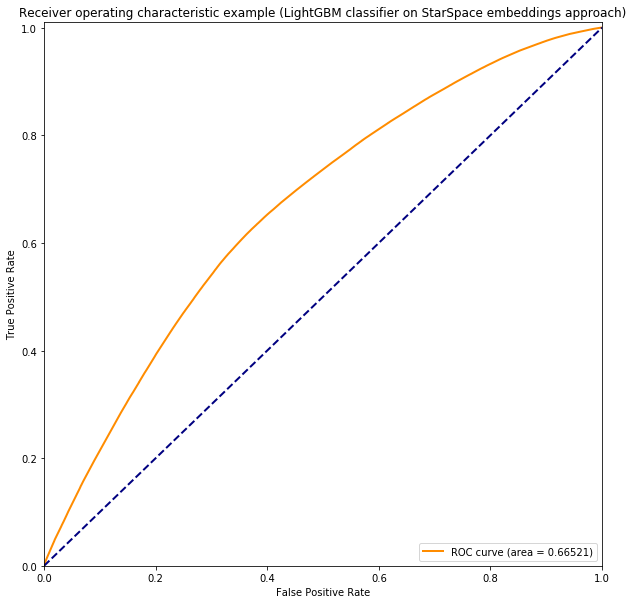

In [125]:
plot_roc_auc(fpr, tpr, 'LightGBM classifier on StarSpace embeddings approach')

## Ensemble

In [ ]:
ens_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', EnsembleBasedRecommender(
            base_estimators=[
                FactorizationMachineBasedRecommender(),
                LightGBMBasedRecommender(),
                XGBoostBasedRecommender()
            ]
        ))
    ]
)

In [ ]:
ens_classifier_pipeline.fit(X_train, y_train.values)

In [ ]:
y_pred = ens_classifier_pipeline.predict_proba(X_test)

In [ ]:
y_pred.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plot_roc_auc(fpr, tpr, 'Ensemble')

# Submission

In [ ]:
ens_classifier_pipeline.fit(X, y.values)

In [ ]:
y_pred_subm = ens_classifier_pipeline.predict_proba(X_for_submission)

In [ ]:
y_pred_subm.shape

In [ ]:
X_for_submission['target'] = y_pred_subm

In [ ]:
X_for_submission[['id', 'target']].to_csv(os.path.join(data_directory, 'ensemble_submission_full_train_part.csv'), index=False)

# Conclusion